<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [375]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [376]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [377]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [378]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv file

In [379]:
from darts import TimeSeries
import pandas as pd


In [380]:
data_file_name = 'data/market_data.csv'

In [381]:

# load into a dataframe with valid market calendar days
# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])
# raw_df


In [382]:
# raw_df.index

In [383]:
# type(raw_df.index)

In [384]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [385]:
# raw_df

In [386]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')
# series = TimeSeries.from_dataframe(raw_df, freq='B')


# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


In [387]:
# check for any data gaps
gaps = series.gaps(mode='any')


In [388]:
type(gaps)

pandas.core.frame.DataFrame

In [389]:
# there should be no data gaps
assert(len(gaps.index) == 0)

In [390]:
series = series.slice(pd.Timestamp('1990-01-02'), series.end_time())

In [391]:
# add holidays
series_with_holidays = series.add_holidays(country_code='US')

In [392]:
series_with_holidays

<TimeSeries (DataArray) (Date: 8874, component: 8, sample: 1)>
array([[[3.75637990e-01],
        [3.82095516e-01],
        [3.70794189e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.85324840e-01],
        [3.88553583e-01],
        [3.81019183e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.84248569e-01],
        [3.96088036e-01],
        [3.82095445e-01],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.70670013e+02],
        [3.73100006e+02],
        [3.67170013e+02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.68970001e+02],
        [3.72059998e+02],
        [3.66500000e+02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Stock Splits' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [393]:
from darts.dataprocessing.transformers import Scaler

ser_scaler = Scaler(verbose=True, n_jobs=-1)
series_scaled = ser_scaler.fit_transform(series=series_with_holidays)
series_scaled

Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 8874, component: 8, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Stock Splits' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [394]:
# series = TimeSeries.from_dataframe(raw_df[['Close']], freq='B')
target = series_scaled.univariate_component('Close')
target

<TimeSeries (DataArray) (Date: 8874, component: 1, sample: 1)>
array([[[2.95591813e-05]],

       [[3.51905557e-05]],

       [[6.47497370e-05]],

       ...,

       [[9.68351867e-01]],

       [[9.61394502e-01]],

       [[9.60897542e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Prepare Past Covariates

In [395]:

# open = TimeSeries.from_dataframe(raw_df[['Open']], freq='B')
# low = TimeSeries.from_dataframe(raw_df[['Low']], freq='B')
# high = TimeSeries.from_dataframe(raw_df[['High']], freq='B')
# volume = TimeSeries.from_dataframe(raw_df[['Volume']], freq='B')
# dividends = TimeSeries.from_dataframe(raw_df[['Dividends']], freq='B')
# stock_splits = TimeSeries.from_dataframe(raw_df[['Stock Splits']], freq='B')

# past_covariates = open.stack(low).stack(high).stack(volume).stack(dividends).stack(stock_splits)

past_covariates = series_scaled.drop_columns(col_names=['Close', 'holidays'])
past_covariates



<TimeSeries (DataArray) (Date: 8874, component: 6, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        [6.48392531e-02],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        [1.44675383e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        [1.60404123e-01],
        [0.00000000e+00],
        [0.00000000e+00]],
...
       [[9.61527780e-01],
        [9.71244473e-01],
        [9.74457290e-01],
        [2.54704794e-02],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        [2.26024398e-02],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        [2.27148217e-02],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Dividends' 'Stock Splits'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Stack broad market indicators to past covariates

In [396]:
spx = TimeSeries.from_csv('data/spx.csv', time_col='Date', freq='B')
spx

<TimeSeries (DataArray) (Date: 25051, component: 6, sample: 1)>
array([[[1.76599998e+01],
        [1.76599998e+01],
        [1.76599998e+01],
        [1.76599998e+01],
        [1.76599998e+01],
        [0.00000000e+00]],

       [[           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan],
        [           nan]],

       [[1.77600002e+01],
        [1.77600002e+01],
        [1.77600002e+01],
        [1.77600002e+01],
        [1.77600002e+01],
        [0.00000000e+00]],
...
       [[4.72506982e+03],
        [4.72929004e+03],
        [4.69970996e+03],
        [4.70481006e+03],
        [4.70481006e+03],
        [3.95076000e+09]],

       [[4.69741992e+03],
        [4.72677979e+03],
        [4.68752979e+03],
        [4.68868018e+03],
        [4.68868018e+03],
        [3.71548000e+09]],

       [[4.69056982e+03],
        [4.72149023e+03],
        [4.68210986e+03],
        [4.69724023e+03],
        [4.69724023e+03],
        [3.84437000e+09]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1927-12-30 1928-01-02 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [397]:
spx_sliced = spx.slice_intersect(target)

spx_scaler = Scaler()
spx_scaled = spx_scaler.fit_transform(spx_sliced)

past_covariates.stack(spx_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [1.42698474e-02],
        [1.42698474e-02],
        [1.28552500e-02]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [1.40632328e-02],
        [1.40632328e-02],
        [1.55000682e-02]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [9.79616094e-01],
        [9.79616094e-01],
        [3.43998553e-01]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [9.76032552e-01],
        [9.76032552e-01],
        [3.23434348e-01]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [9.77934322e-01],
        [9.77934322e-01],
        [3.34699735e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [398]:
ndx = TimeSeries.from_csv('data/ndx.csv', time_col='Date', freq='B')
ndx

<TimeSeries (DataArray) (Date: 9984, component: 6, sample: 1)>
array([[[1.10620003e+02],
        [1.12160004e+02],
        [1.10565002e+02],
        [1.12139999e+02],
        [1.12139999e+02],
        [1.53160000e+08]],

       [[1.12139999e+02],
        [1.12540001e+02],
        [1.10779999e+02],
        [1.10824997e+02],
        [1.10824997e+02],
        [1.64640000e+08]],

       [[1.10839996e+02],
        [1.11184998e+02],
        [1.10120003e+02],
        [1.10870003e+02],
        [1.10870003e+02],
        [1.47300000e+08]],
...
       [[1.64132598e+04],
        [1.64710801e+04],
        [1.63521396e+04],
        [1.63684902e+04],
        [1.63684902e+04],
        [5.44995000e+09]],

       [[1.62907803e+04],
        [1.64194395e+04],
        [1.62764297e+04],
        [1.62820098e+04],
        [1.62820098e+04],
        [5.28922000e+09]],

       [[1.62817402e+04],
        [1.64153906e+04],
        [1.62491904e+04],
        [1.63059805e+04],
        [1.63059805e+04],
        [5.23282000e+09]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1985-10-01 1985-10-02 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [399]:
ndx_sliced = ndx.slice_intersect(target)

ndx_scaler = Scaler()
ndx_scaled = ndx_scaler.fit_transform(ndx_sliced)

past_covariates.stack(ndx_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [3.73500605e-03],
        [3.73500605e-03],
        [1.63683350e-02]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [3.63794248e-03],
        [3.63794248e-03],
        [2.36059520e-02]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [9.67845943e-01],
        [9.67845943e-01],
        [4.67512263e-01]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [9.62680341e-01],
        [9.62680341e-01],
        [4.53643616e-01]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [9.64112145e-01],
        [9.64112145e-01],
        [4.48777121e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [400]:
rut = TimeSeries.from_csv('data/rut.csv', time_col='Date', freq='B')
rut

<TimeSeries (DataArray) (Date: 9477, component: 6, sample: 1)>
array([[[1.67440002e+02],
        [1.68979996e+02],
        [1.67440002e+02],
        [1.68970001e+02],
        [1.68970001e+02],
        [1.79800000e+08]],

       [[1.68970001e+02],
        [1.70539993e+02],
        [1.68750000e+02],
        [1.70539993e+02],
        [1.70539993e+02],
        [1.78000000e+08]],

       [[1.70529999e+02],
        [1.70949997e+02],
        [1.70149994e+02],
        [1.70429993e+02],
        [1.70429993e+02],
        [1.54400000e+08]],
...
       [[1.99517004e+03],
        [1.99517004e+03],
        [1.95803003e+03],
        [1.95919995e+03],
        [1.95919995e+03],
        [3.95076000e+09]],

       [[1.96434998e+03],
        [1.97054004e+03],
        [1.95669995e+03],
        [1.95772998e+03],
        [1.95772998e+03],
        [3.71548000e+09]],

       [[1.94350000e+03],
        [1.96798999e+03],
        [1.94177002e+03],
        [1.95114001e+03],
        [1.95114001e+03],
        [3.84437000e+09]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1987-09-10 1987-09-11 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [401]:
rut_sliced = rut.slice_intersect(target)

rut_scaler = Scaler()
rut_scaled = rut_scaler.fit_transform(rut_sliced)

past_covariates.stack(rut_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [2.20016169e-02],
        [2.20016169e-02],
        [1.41468878e-02]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [2.23630735e-02],
        [2.23630735e-02],
        [1.67882453e-02]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [7.91929137e-01],
        [7.91929137e-01],
        [3.44856903e-01]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [7.91296597e-01],
        [7.91296597e-01],
        [3.24319606e-01]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [7.88460886e-01],
        [7.88460886e-01],
        [3.35570253e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [402]:
tnx = TimeSeries.from_csv('data/tnx.csv', time_col='Date', freq='B')
tnx

<TimeSeries (DataArray) (Date: 16179, component: 6, sample: 1)>
array([[[4.05999994],
        [4.05999994],
        [4.05999994],
        [4.05999994],
        [4.05999994],
        [0.        ]],

       [[4.03000021],
        [4.03000021],
        [4.03000021],
        [4.03000021],
        [4.03000021],
        [0.        ]],

       [[3.99000001],
        [3.99000001],
        [3.99000001],
        [3.99000001],
        [3.99000001],
        [0.        ]],
...
       [[3.97799993],
        [4.0079999 ],
        [3.89400005],
        [3.90700006],
        [3.90700006],
        [0.        ]],

       [[3.97399998],
        [4.00600004],
        [3.97099996],
        [3.99099994],
        [3.99099994],
        [0.        ]],

       [[4.03800011],
        [4.09899998],
        [3.95299983],
        [4.04199982],
        [4.04199982],
        [0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1962-01-02 1962-01-03 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [403]:
tnx_sliced = tnx.slice_intersect(target)

tnx_scaler = Scaler()
tnx_scaled = tnx_scaler.fit_transform(tnx_sliced)

past_covariates.stack(tnx_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [8.66138974e-01],
        [8.66138974e-01],
        [0.00000000e+00]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [8.71958985e-01],
        [8.71958985e-01],
        [0.00000000e+00]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [3.96694214e-01],
        [3.96694214e-01],
        [0.00000000e+00]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [4.06471874e-01],
        [4.06471874e-01],
        [0.00000000e+00]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [4.12408305e-01],
        [4.12408305e-01],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [404]:
vix = TimeSeries.from_csv('data/vix.csv', time_col='Date', freq='B')
vix

<TimeSeries (DataArray) (Date: 8874, component: 6, sample: 1)>
array([[[17.23999977],
        [17.23999977],
        [17.23999977],
        [17.23999977],
        [17.23999977],
        [ 0.        ]],

       [[18.19000053],
        [18.19000053],
        [18.19000053],
        [18.19000053],
        [18.19000053],
        [ 0.        ]],

       [[19.21999931],
        [19.21999931],
        [19.21999931],
        [19.21999931],
        [19.21999931],
        [ 0.        ]],
...
       [[13.35000038],
        [14.22000027],
        [13.32999992],
        [14.03999996],
        [14.03999996],
        [ 0.        ]],

       [[13.93000031],
        [14.19999981],
        [13.64000034],
        [14.13000011],
        [14.13000011],
        [ 0.        ]],

       [[14.23999977],
        [14.57999992],
        [13.28999996],
        [13.35000038],
        [13.35000038],
        [ 0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [405]:
vix_sliced = vix.slice_intersect(target)

vix_scaler = Scaler()
vix_scaled = vix_scaler.fit_transform(vix_sliced)

past_covariates.stack(vix_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [1.10129153e-01],
        [1.10129153e-01],
        [0.00000000e+00]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [1.23045546e-01],
        [1.23045546e-01],
        [0.00000000e+00]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [6.66213389e-02],
        [6.66213389e-02],
        [0.00000000e+00]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [6.78449984e-02],
        [6.78449984e-02],
        [0.00000000e+00]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [5.72399717e-02],
        [5.72399717e-02],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [406]:
dxy = TimeSeries.from_csv('data/dxy.csv', time_col='Date', freq='B')
dxy

<TimeSeries (DataArray) (Date: 13830, component: 6, sample: 1)>
array([[[120.52999878],
        [120.52999878],
        [120.52999878],
        [120.52999878],
        [120.52999878],
        [  0.        ]],

       [[120.51999664],
        [120.51999664],
        [120.51999664],
        [120.51999664],
        [120.51999664],
        [  0.        ]],

       [[120.48999786],
        [120.48999786],
        [120.48999786],
        [120.48999786],
        [120.48999786],
        [  0.        ]],
...
       [[102.15000153],
        [102.73000336],
        [102.08000183],
        [102.45999908],
        [102.45999908],
        [  0.        ]],

       [[102.45999908],
        [102.52999878],
        [102.15000153],
        [102.41999817],
        [102.41999817],
        [  0.        ]],

       [[102.39499664],
        [103.10099792],
        [101.90799713],
        [102.43499756],
        [102.43499756],
        [  0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1971-01-04 1971-01-05 ... 2024-01-05
  * component  (component) object 'Open' 'High' 'Low' ... 'Adj Close' 'Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [407]:
dxy_sliced = dxy.slice_intersect(target)

dxy_scaler = Scaler()
dxy_scaled = rut_scaler.fit_transform(dxy_sliced)

past_covariates.stack(dxy_scaled)

<TimeSeries (DataArray) (Date: 8874, component: 12, sample: 1)>
array([[[2.38627982e-05],
        [1.96231431e-05],
        [2.42161060e-05],
        ...,
        [4.63183361e-01],
        [4.63183361e-01],
        [0.00000000e+00]],

       [[4.91288740e-05],
        [3.64442942e-05],
        [5.12807903e-05],
        ...,
        [4.65805860e-01],
        [4.65805860e-01],
        [0.00000000e+00]],

       [[4.63216529e-05],
        [5.60690754e-05],
        [5.41295648e-05],
        ...,
...
        ...,
        [6.28000755e-01],
        [6.28000755e-01],
        [0.00000000e+00]],

       [[9.65857544e-01],
        [9.70827716e-01],
        [9.70910434e-01],
        ...,
        [6.27193797e-01],
        [6.27193797e-01],
        [0.00000000e+00]],

       [[9.61423426e-01],
        [9.68118834e-01],
        [9.69136966e-01],
        ...,
        [6.27496387e-01],
        [6.27496387e-01],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-05
  * component  (component) <U12 'Open' 'High' 'Low' ... 'Adj Close' 'Volume_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Prepare Future Covariates

In [408]:
future_covariates = series_scaled.univariate_component('holidays')

Prepare train and validation splits

In [409]:
val_start = pd.Timestamp('2023-05-05')
train, val = target.split_before(val_start)

past_covariates_train, past_covariates_pred = past_covariates.split_before(val_start)


In [410]:
len(train), len(val)

(8698, 176)

In [411]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[2.95591813e-05]],

       [[3.51905557e-05]],

       [[6.47497370e-05]],

       [[3.94134629e-05]],

       [[5.48958451e-05]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 1990-01-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [412]:
# there should be no gaps in the training data
assert(len(train.gaps().index) == 0)


In [413]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.80642582]],

       [[0.80122769]],

       [[0.7969392 ]],

       [[0.81074018]],

       [[0.80502227]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-05-11
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [414]:
# there should be no gaps in the validation data
assert(len(val.gaps().index) == 0)


Plot data splits

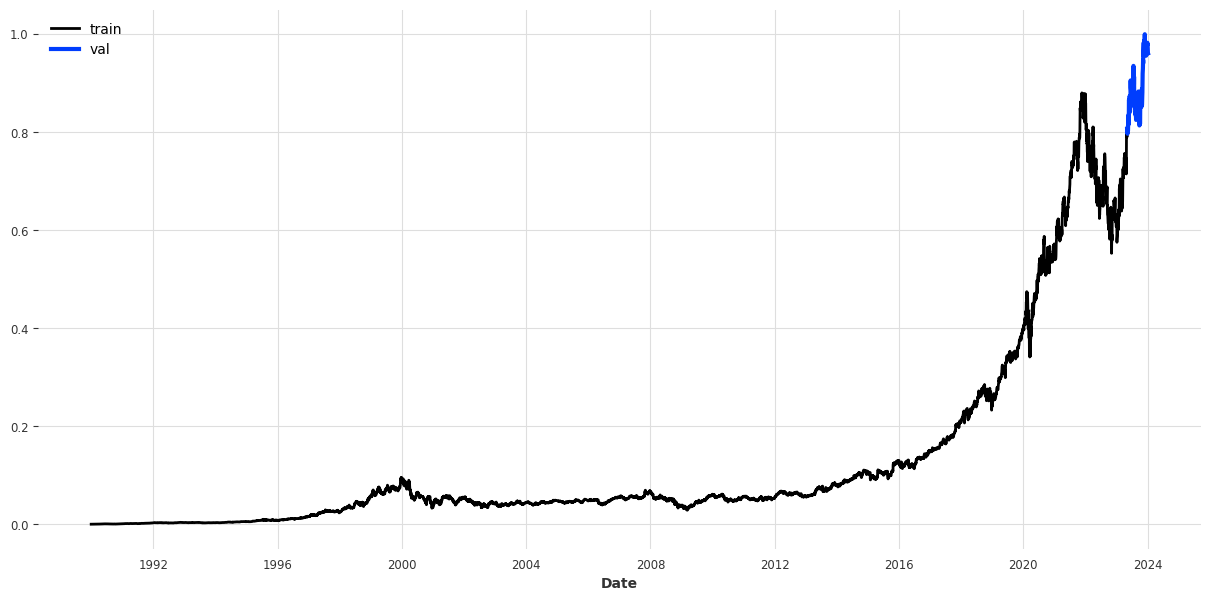

In [415]:
import matplotlib.pyplot as plt

train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

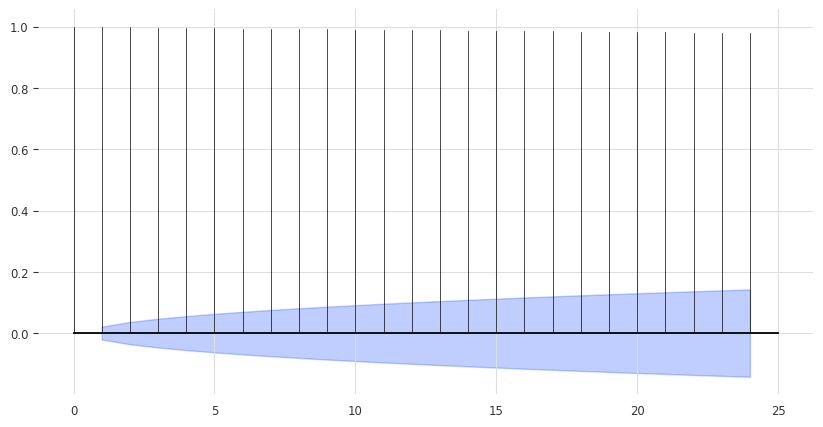

In [416]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [417]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    "transformer": scaler
}



In [418]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 100 # model training epochs

Model hyperparameter selection

In [419]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [420]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [421]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [422]:
# train model

model.fit(train, epochs=n_epochs, past_covariates=past_covariates_train, future_covariates=future_covariates, num_loader_workers=10) # 


Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 1.6 K 
5 | future_cov_projection | _ResidualBlock   | 2.2 K 
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.433    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders={'cyclic': {'future': ['dayofweek', 'month', 'quarter']}, 'datetime_attribute': {'future': ['dayofweek', 'month', 'quarter', 'year']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'transformer': Scaler}, n_epochs=100, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt)

In [423]:
# save model
model.save(saved_model_name)


In [424]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=train, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [425]:
pred

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.79007591, 0.77269659, 0.77425332, ..., 0.77364754,
         0.77616198, 0.77990861]],

       [[0.76975255, 0.7769406 , 0.72444945, ..., 0.75529469,
         0.73502931, 0.76296409]],

       [[0.73555597, 0.76219643, 0.76417036, ..., 0.76618356,
         0.76296059, 0.77366466]],

       ...,

       [[0.7512473 , 0.77629547, 0.76829632, ..., 0.76862332,
         0.74144917, 0.75145224]],

       [[0.79327426, 0.77060818, 0.76731493, ..., 0.74970947,
         0.77868038, 0.79022693]],

       [[0.781659  , 0.7949709 , 0.78222871, ..., 0.7947242 ,
         0.7775086 , 0.76834571]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [426]:
pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
pred2

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.88127409, 0.8524522 , 0.85728005, ..., 0.86942315,
         0.85012449, 0.90244768]],

       [[0.83624925, 0.89027447, 0.85957554, ..., 0.83116043,
         0.86507031, 0.88493093]],

       [[0.87965267, 0.87246586, 0.86998152, ..., 0.87209102,
         0.85186194, 0.83085301]],

       ...,

       [[0.86207435, 0.83182976, 0.84492311, ..., 0.85811178,
         0.83243585, 0.84389145]],

       [[0.86877694, 0.8679737 , 0.86295844, ..., 0.85694271,
         0.8554205 , 0.87622184]],

       [[0.8351647 , 0.82119667, 0.83547418, ..., 0.84950197,
         0.83524848, 0.83028694]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-07-05 2023-07-06 ... 2023-08-31
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [427]:
pred3_series = target.slice(target.start_time(), pred2_series.end_time()+pd.Timedelta(days=60))
pred3 = model.predict(pred_horizon, series=pred3_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
pred3

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.84969443, 0.85328983, 0.89494556, ..., 0.85333771,
         0.85886153, 0.83216297]],

       [[0.85593654, 0.84156092, 0.82951223, ..., 0.8442412 ,
         0.84451519, 0.89833812]],

       [[0.86582029, 0.84777597, 0.84836745, ..., 0.83002932,
         0.85016605, 0.87016733]],

       ...,

       [[0.83491694, 0.84969969, 0.8472452 , ..., 0.84133244,
         0.8442637 , 0.82553668]],

       [[0.84879594, 0.87753522, 0.85366359, ..., 0.84567161,
         0.845785  , 0.83800293]],

       [[0.84323772, 0.82013706, 0.84252258, ..., 0.80554651,
         0.82989776, 0.85762923]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-09-04 2023-09-05 ... 2023-10-31
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [428]:
pred4_series = target.slice(target.start_time(), pred3_series.end_time()+pd.Timedelta(days=60))
pred4 = model.predict(pred_horizon, series=pred4_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
pred4

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.90066022, 0.89910026, 0.91632231, ..., 0.89869813,
         0.88008391, 0.92672335]],

       [[0.87507862, 0.88544535, 0.86576324, ..., 0.88592008,
         0.88621051, 0.88632758]],

       [[0.89563578, 0.90944072, 0.89836962, ..., 0.90228839,
         0.8539297 , 0.89965664]],

       ...,

       [[0.8773606 , 0.8773208 , 0.87058023, ..., 0.8987004 ,
         0.87670756, 0.87323524]],

       [[0.87105553, 0.86279726, 0.86422623, ..., 0.86593621,
         0.91712666, 0.86223562]],

       [[0.89047743, 0.88408196, 0.89419941, ..., 0.90011315,
         0.8296499 , 0.89984239]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-11-01 2023-11-02 ... 2023-12-28
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [429]:
pred5_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=30))
pred5 = model.predict(pred_horizon, series=pred5_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
pred5

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.85128806, 0.87259959, 0.84753677, ..., 0.84550689,
         0.84913391, 0.85422629]],

       [[0.85566696, 0.8545569 , 0.83427498, ..., 0.87072455,
         0.86273415, 0.85247446]],

       [[0.85919427, 0.85470974, 0.8354431 , ..., 0.85634015,
         0.84894148, 0.85918259]],

       ...,

       [[0.81794982, 0.85278527, 0.80092014, ..., 0.8542911 ,
         0.85413052, 0.89364411]],

       [[0.86304699, 0.85035405, 0.86445381, ..., 0.85740852,
         0.85567622, 0.86674754]],

       [[0.8380278 , 0.84856326, 0.84223049, ..., 0.85558465,
         0.85128213, 0.84599776]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-06-05 2023-06-06 ... 2023-08-01
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0, 0.5, 'Price [scaled 0-1]')

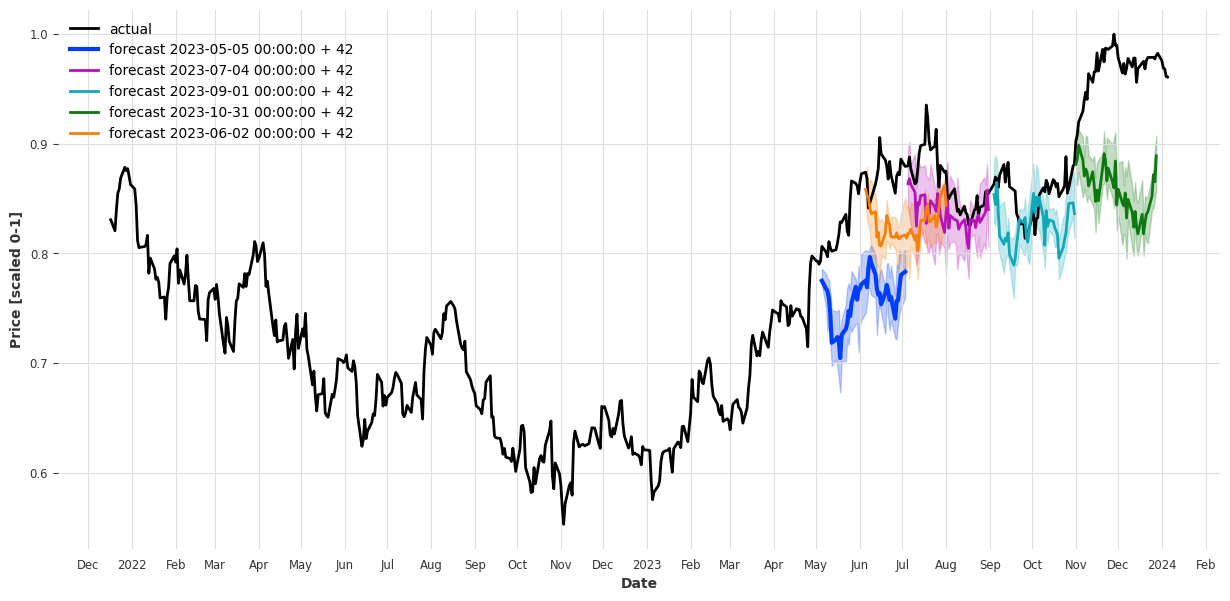

In [430]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = target.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
ax = actual.plot(label='actual')
pred.plot(label=f'forecast {val_start} + {pred_horizon}', lw=3)
pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
pred3.plot(label=f'forecast {pred3_series.end_time()} + {pred_horizon}')
pred4.plot(label=f'forecast {pred4_series.end_time()} + {pred_horizon}')
pred5.plot(label=f'forecast {pred5_series.end_time()} + {pred_horizon}')
plt.legend()

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Price [scaled 0-1]')


Backtest Model


Backtest model on the full range of test data

In [431]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [432]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=60)
forecast_horizon = pred_horizon # pred_horizon
backtest = eval_model(model=model, series=target, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_covariates, future_covariates=future_covariates)


Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest RMSE = 0.0817831667247364


Text(0, 0.5, 'Price [scaled 0-1]')

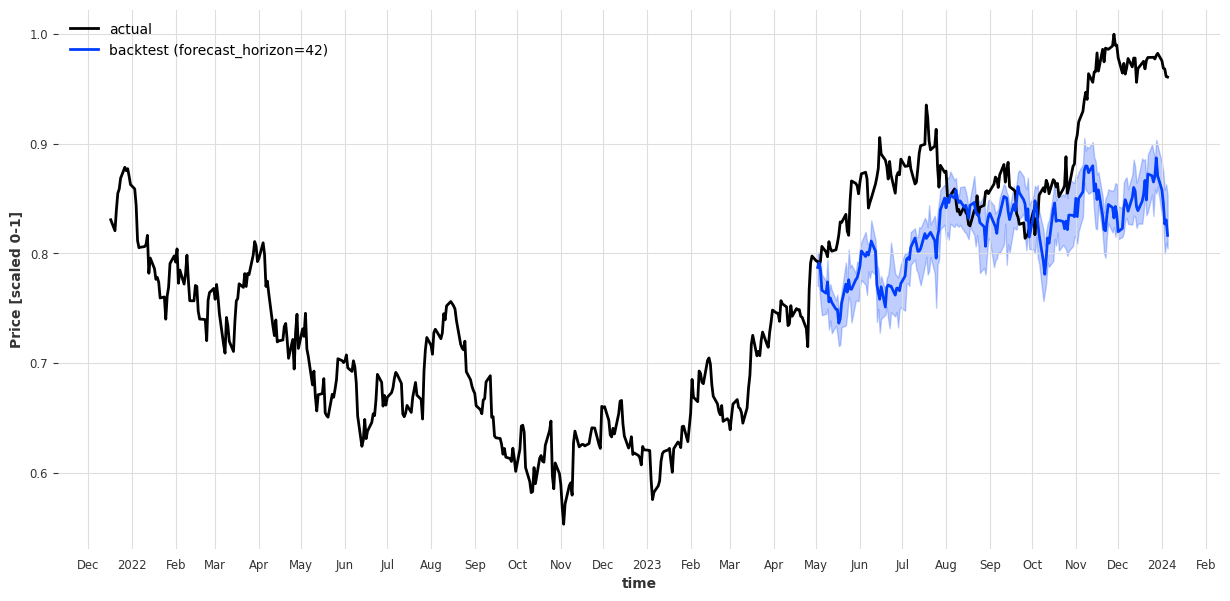

In [433]:
import matplotlib.dates as mdates

# plot results
ax = actual.plot(label='actual')
backtest.plot(label=f'backtest (forecast_horizon={forecast_horizon})')
print('Backtest RMSE = {}'.format(rmse(target, backtest)))

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Price [scaled 0-1]')
